In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
log = "data/gemm_mnk_std.txt"
with open(log) as f:
    lines = f.readlines()
    times = []
    flop_bytes = []
    m = []
    n = []
    k = []
    perfs = []
    for line in lines:
        #m.append(float(line.split()[0]))
        #n.append(float(line.split()[1]))
        #k.append(float(line.split()[2]))
        flop_bytes.append(float(line.split()[3]))
        times.append(float(line.split()[4]))
        perfs.append(float(line.split()[5]))

### Visualizing the dataset

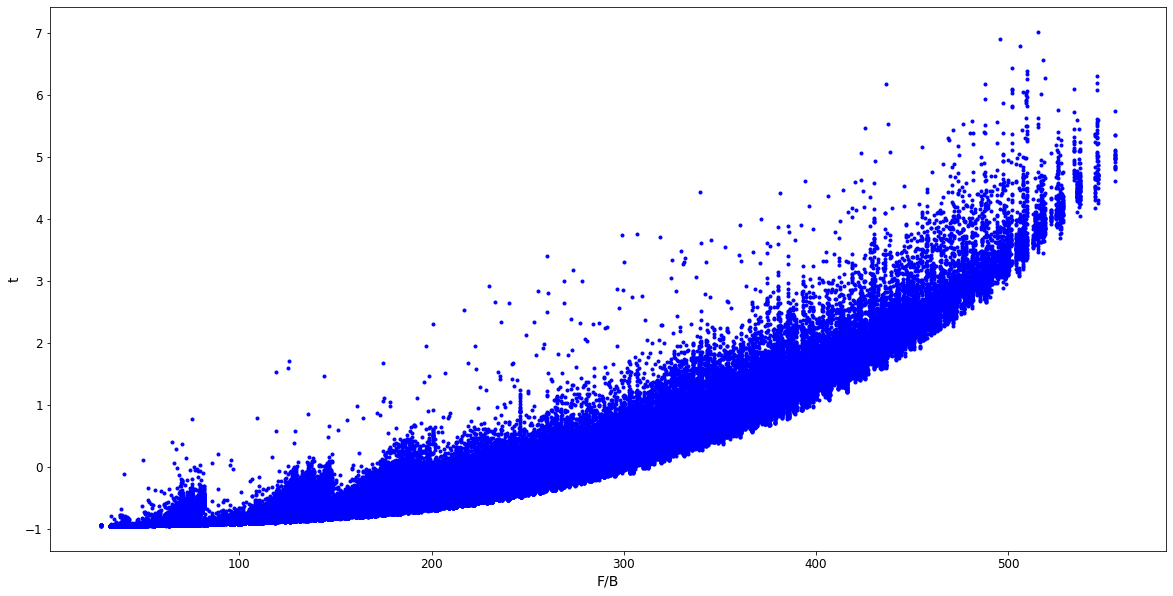

In [8]:
plt.xlabel("F/B")
plt.ylabel("t")
plt.plot(flop_bytes,times,'.',color='b')
plt.show()

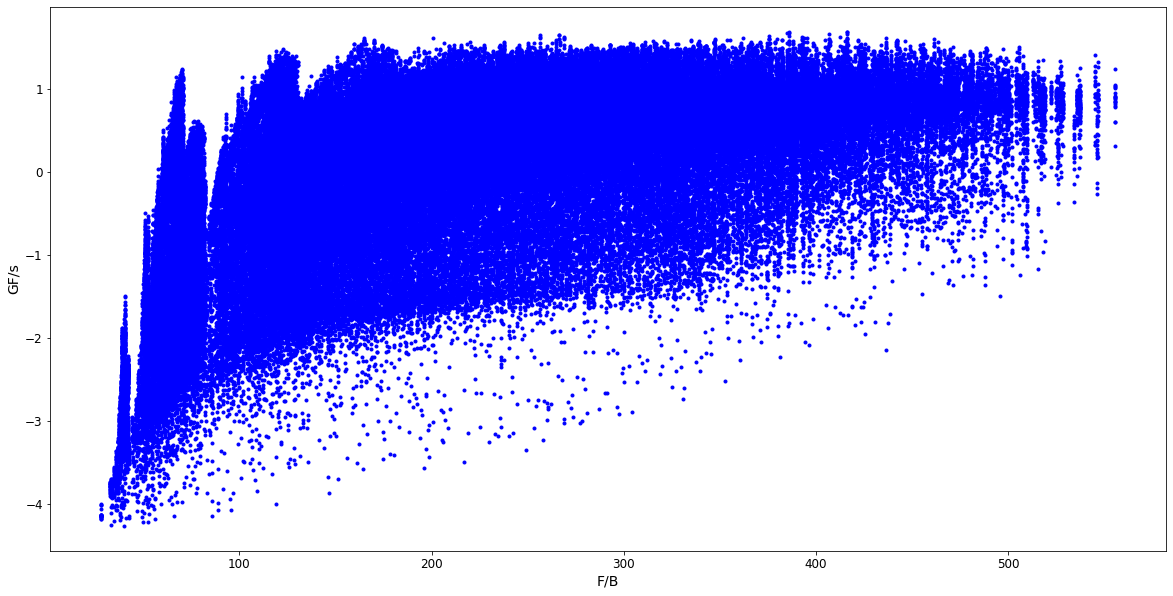

In [11]:
plt.xlabel("F/B")
plt.ylabel("GF/s")
#plt.xlim(300,302)
plt.plot(flop_bytes,perfs,'.',color='b')
plt.show()

### Shuffle dataset

In [12]:
import random

def shuffle_data(log):
    fw = open(log.split(".")[0] + "_shuffled.txt", "w")
    with open(log) as f:
        lines = f.readlines()
        random.shuffle(lines)
        for line in lines:
            fw.write(line)
    fw.close()

In [13]:
shuffle_data(log)

### tf.data API

In [14]:
def cast_to_number(x):
    return tf.strings.to_number(x,out_type=tf.float64)

def split_features_labels(x):
    nn_input = tf.stack([x[0],x[1],x[2]])
    nn_gt = x[5]
    return (nn_input, nn_gt[...,tf.newaxis])

In [15]:
#filename = "data/gemm2000_shuffled.txt"
filename = "data/gemm_mnk_std_shuffled.txt"
ds_file = tf.data.TextLineDataset(filename)
ds_file = ds_file.map(tf.strings.split)
ds_file = ds_file.map(cast_to_number)
ds_file = ds_file.map(split_features_labels)

### Splitting dataset

In [16]:
DATASET_SIZE = len(open(filename).readlines())

In [17]:
DATASET_SIZE

160000

In [18]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_dataset = ds_file.take(train_size)
test_dataset = ds_file.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

**Iterator**

In [19]:
train_dataset = train_dataset.batch(5)
it = iter(train_dataset)

**Sample point**

In [20]:
x = next(it)
x

(<tf.Tensor: id=125, shape=(5, 3), dtype=float64, numpy=
 array([[ 900.,  600., 1000.],
        [  50.,  600.,  800.],
        [ 750.,  250.,  850.],
        [ 550.,  450.,  250.],
        [  50.,  650.,  400.]])>,
 <tf.Tensor: id=126, shape=(5, 1), dtype=float64, numpy=
 array([[ 0.88276564],
        [-1.34131864],
        [ 0.62443133],
        [ 0.26422067],
        [-0.6081023 ]])>)

### Neural Network

>$f = W_2\phi(W_1x)$

In [21]:
QUANTILES = [0.15,0.5,0.85]

tf.keras.backend.set_floatx('float64')

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00), input_shape=(None,3))
    self.d2 = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d3 = tf.keras.layers.Dense(64, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d4 = tf.keras.layers.Dense(len(QUANTILES), activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return self.d4(x)

# Create an instance of the model
model = MyModel()

In [22]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [23]:
input_x, gt_y = next(it)

In [24]:
with tf.GradientTape() as tape:
    nn_out = model(input_x)
    loss_out = loss(gt_y, nn_out) 
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [25]:
input_x, gt_y, nn_out, loss_out

(<tf.Tensor: id=127, shape=(5, 3), dtype=float64, numpy=
 array([[ 700.,  550.,  800.],
        [ 800.,  100.,  150.],
        [ 250.,  950.,  150.],
        [ 300.,  100.,  800.],
        [1000.,  100.,  650.]])>,
 <tf.Tensor: id=128, shape=(5, 1), dtype=float64, numpy=
 array([[ 0.59983127],
        [-1.61336605],
        [-0.13510453],
        [-1.42502365],
        [-0.13211017]])>,
 <tf.Tensor: id=234, shape=(5, 3), dtype=float64, numpy=
 array([[-2.27366941,  0.04246274, -0.02254482],
        [ 0.4948161 , -0.31613646, -0.85474182],
        [-1.09030588, -0.73869641,  1.26790426],
        [-1.02513907, -0.24322353, -1.63267884],
        [ 0.10174554, -0.9856035 , -1.48759196]])>,
 <tf.Tensor: id=256, shape=(), dtype=float64, numpy=1.5415388345718384>)

In [175]:
len(gradients) ## W!, B1, W2, B2

4

In [33]:
test_dataset = test_dataset.batch(1)
it_test = iter(test_dataset)

In [33]:
a,b = next(it_test)

In [34]:
a

<tf.Tensor: id=12432, shape=(1, 2), dtype=float64, numpy=array([[1.2400e+03, 1.5376e+06]])>

In [35]:
nn_out = model(a)

In [36]:
nn_out

<tf.Tensor: id=12443, shape=(1, 1), dtype=float64, numpy=array([[0.]])>

### Wrap up

In [26]:
@tf.function
def multi_quantile_loss(quantiles,y,f):
    e = (y-f)
    loss = 0
    for k in range(len(quantiles)):
        q = quantiles[k]
        loss += tf.keras.backend.mean(q*e[:,k] + tf.keras.backend.clip(-e[:,k],tf.keras.backend.epsilon(),np.inf))
    return loss

In [27]:
model = MyModel()
#loss = tf.keras.losses.MeanAbsoluteError()
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.RMSprop(lr_schedule)
#optimizer = tf.keras.optimizers.Adam()
mean_loss = tf.keras.metrics.Mean(name='mean_loss')

@tf.function
def train_step(x,gt):
    with tf.GradientTape() as tape:
        nn_out = model(x)
        loss_out = multi_quantile_loss(QUANTILES,gt, nn_out) 
        reg_loss = tf.math.add_n(model.losses)
        loss_out = loss_out + reg_loss
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    mean_loss(loss_out)

In [28]:
def train_model():
    i = 0
    for input_x, gt_y in train_dataset:
        i = i+1
        train_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss.result()))
            mean_loss.reset_states()

In [29]:

train_model()

Iter 100, Loss: 0.9147298161861285
Iter 200, Loss: 0.8340699967879343
Iter 300, Loss: 0.7896982600584026
Iter 400, Loss: 0.793764727661786
Iter 500, Loss: 0.7774674081701558
Iter 600, Loss: 0.7700029479847511
Iter 700, Loss: 0.7448086503623563
Iter 800, Loss: 0.7185523093237987
Iter 900, Loss: 0.7239629098499093
Iter 1000, Loss: 0.7789736348229561
Iter 1100, Loss: 0.7719812773036797
Iter 1200, Loss: 0.7465186541320908
Iter 1300, Loss: 0.72714708595961
Iter 1400, Loss: 0.7408648265851246
Iter 1500, Loss: 0.76560406942443
Iter 1600, Loss: 0.7615547877655047
Iter 1700, Loss: 0.6957135020371858
Iter 1800, Loss: 0.7557893986668739
Iter 1900, Loss: 0.748810212055671
Iter 2000, Loss: 0.7710344242917542
Iter 2100, Loss: 0.800357984941841
Iter 2200, Loss: 0.6907237226485479
Iter 2300, Loss: 0.7454540151360348
Iter 2400, Loss: 0.7659720485274921
Iter 2500, Loss: 0.7173656566918589
Iter 2600, Loss: 0.7486200469989948
Iter 2700, Loss: 0.7490278168138909
Iter 2800, Loss: 0.7021103214002958
Iter 290

Iter 22700, Loss: 0.6488398020459019
Iter 22800, Loss: 0.6956052468313568
Iter 22900, Loss: 0.6283164271116765
Iter 23000, Loss: 0.6381102176942414
Iter 23100, Loss: 0.6900020451246727
Iter 23200, Loss: 0.672157111522058
Iter 23300, Loss: 0.6831842256871644
Iter 23400, Loss: 0.6276480790424624
Iter 23500, Loss: 0.6360756286754973
Iter 23600, Loss: 0.6317434183882403
Iter 23700, Loss: 0.6475831878814136
Iter 23800, Loss: 0.6441287154345132
Iter 23900, Loss: 0.6688260697602105
Iter 24000, Loss: 0.6347515482147617
Iter 24100, Loss: 0.6387600371469915
Iter 24200, Loss: 0.6050937398816886
Iter 24300, Loss: 0.6625725559561805
Iter 24400, Loss: 0.659932591371362
Iter 24500, Loss: 0.6707532579430994
Iter 24600, Loss: 0.6252920435254482
Iter 24700, Loss: 0.6011764823203811
Iter 24800, Loss: 0.6592440857416251
Iter 24900, Loss: 0.6197622405126482
Iter 25000, Loss: 0.6067353990798586
Iter 25100, Loss: 0.6692865239742283
Iter 25200, Loss: 0.6634202175201038
Iter 25300, Loss: 0.5884798428715913
Ite

In [29]:
mean_loss_test = tf.keras.metrics.Mean(name='mean_loss_test')

@tf.function
def test_step(x, gt):
    nn_out = model(x)
    test_loss = quantile_loss(QUANTILE,gt, nn_out)

    mean_loss_test(test_loss)
    
    return nn_out

In [30]:
def test_model():
    i = 0
    for input_x, gt_y in test_dataset:
        i = i+1
        result = test_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss_test.result()))
            print(input_x.numpy(), result.numpy(), gt_y.numpy())
        mean_loss_test.reset_states()

In [37]:
test_model()

Iter 100, Loss: 119.79499816894531
[[   830. 688900.]] [[0.]] [[119.795]]
Iter 200, Loss: 340.4159851074219
[[1.2200e+03 1.4884e+06]] [[0.]] [[340.416]]
Iter 300, Loss: 61.887001037597656
[[   680. 462400.]] [[0.]] [[61.887]]
Iter 400, Loss: 42.472999572753906
[[   590. 348100.]] [[0.]] [[42.473]]
Iter 500, Loss: 84.2249984741211
[[   760. 577600.]] [[0.]] [[84.225]]
Iter 600, Loss: 732.8790283203125
[[1.5900e+03 2.5281e+06]] [[0.]] [[732.879]]
Iter 700, Loss: 491.5
[[1.4300e+03 2.0449e+06]] [[0.]] [[491.5]]
Iter 800, Loss: 1.2380000352859497
[[  120. 14400.]] [[0.]] [[1.238]]
Iter 900, Loss: 449.5570068359375
[[1.3400e+03 1.7956e+06]] [[0.]] [[449.557]]
Iter 1000, Loss: 167.1580047607422
[[   990. 980100.]] [[0.]] [[167.158]]
Iter 1100, Loss: 409.7349853515625
[[1.30e+03 1.69e+06]] [[0.]] [[409.735]]
Iter 1200, Loss: 641.7940063476562
[[1.2500e+03 1.5625e+06]] [[0.]] [[641.794]]
Iter 1300, Loss: 1129.0419921875
[[1.8300e+03 3.3489e+06]] [[0.]] [[1129.042]]
Iter 1400, Loss: 252.1990051

### Eval

In [30]:
def get_quantile_gt(filename,quantile):
    data = {}
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            try:
                data[float(line.split()[3])].append(float(line.split()[5]))
            except KeyError:
                data[float(line.split()[3])] = []
                data[float(line.split()[3])].append(float(line.split()[5]))

    for k,v in data.items():
        v.sort()
        
    x_q = []
    y_q = []
    q = int(quantile*20)
    for k,v in data.items():
        x_q.append(k)
        y_q.append(v[q])
        
    return (x_q,y_q)

In [31]:
x_q1, y_q1 = get_quantile_gt(filename,QUANTILES[0])
x_q2, y_q2 = get_quantile_gt(filename,QUANTILES[1])
x_q3, y_q3 = get_quantile_gt(filename,QUANTILES[2])

In [35]:
eval_size = [250,50,250]
inp = tf.constant(eval_size,shape=(1,3),dtype="float64")
out = model(inp)

In [36]:
out

<tf.Tensor: id=54008, shape=(1, 3), dtype=float64, numpy=array([[-1.54642196, -0.17197845,  0.69876877]])>

In [37]:
import numpy as np

In [155]:
sizes = np.arange(50,1050,50)

In [156]:
x = []
y = []
for t_m in sizes:
    for t_n in sizes:
        for t_k in sizes:
            inp = [float(t_m),float(t_n),float(t_k)]
            inp = tf.constant(inp,shape=(1,3),dtype="float64")
            x.append(float(2*t_m*t_n*t_k)/(1.1*t_m*t_n + 1.2*t_n*t_k + 1.3*t_m*t_k))
            y.append((model(inp).numpy()).reshape(-1))
y = np.array(y)

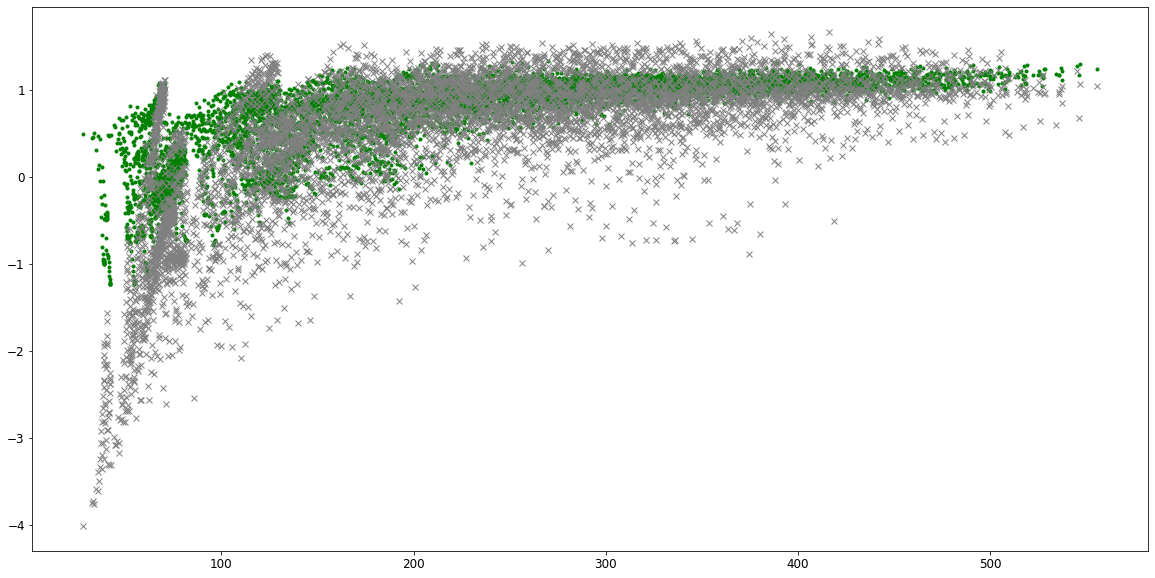

In [236]:
#plt.xlim(500,510)
#plt.yscale('log')
#plot_quantile_compare2("data/gemm2000_shuffled_timeperf_std.txt")
#plt.plot(x,y[:,0],'.',color='r')
#plt.plot(x_q1,y_q1,'x',color='grey')
#plt.plot(x,y[:,1],'.',color='b')
#plt.plot(x_q2,y_q2,'x',color='grey')
plt.plot(x,y[:,2],'.',color='g')
plt.plot(x_q3,y_q3,'x',color='grey')
plt.show()

In [78]:
model.losses

[<tf.Tensor: id=342087, shape=(), dtype=float64, numpy=0.0>,
 <tf.Tensor: id=342088, shape=(), dtype=float64, numpy=0.0>,
 <tf.Tensor: id=342089, shape=(), dtype=float64, numpy=0.0>,
 <tf.Tensor: id=342090, shape=(), dtype=float64, numpy=0.0>]

In [110]:
def get_quantile_gt_time(filename,quantile):
    times_std = 0.0031721245112745983
    times_mean  = 0.00304163517125
    data = {}
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            try:
                data[float(line.split()[3])].append(float(line.split()[4])*times_std + times_mean)
            except KeyError:
                data[float(line.split()[3])] = []
                data[float(line.split()[3])].append(float(line.split()[4])*times_std + times_mean)

    for k,v in data.items():
        v.sort()
        
    x_q = []
    y_q = []
    q = int(quantile*20)
    for k,v in data.items():
        x_q.append(k)
        y_q.append(v[q])
        
    return (x_q,y_q)

In [111]:
tx_q1, ty_q1 = get_quantile_gt_time(filename,QUANTILES[0])
tx_q2, ty_q2 = get_quantile_gt_time(filename,QUANTILES[1])
tx_q3, ty_q3 = get_quantile_gt_time(filename,QUANTILES[2])

In [165]:
perfs_std = 20.44765391998221
perfs_mean  = 87.79658425316
x2 = []
y2 = []
for t_m in sizes:
    for t_n in sizes:
        for t_k in sizes:
            inp = [float(t_m),float(t_n),float(t_k)]
            inp = tf.constant(inp,shape=(1,3),dtype="float64")
            x2.append(float(2*t_m*t_n*t_k)/(1.1*t_m*t_n + 1.2*t_n*t_k + 1.3*t_m*t_k))
            out = (model(inp).numpy()).reshape(-1)
            out = out*perfs_std + perfs_mean
            y2.append(float(2*t_m*t_n*t_k)*1e-9/out)
y2 = np.array(y2)

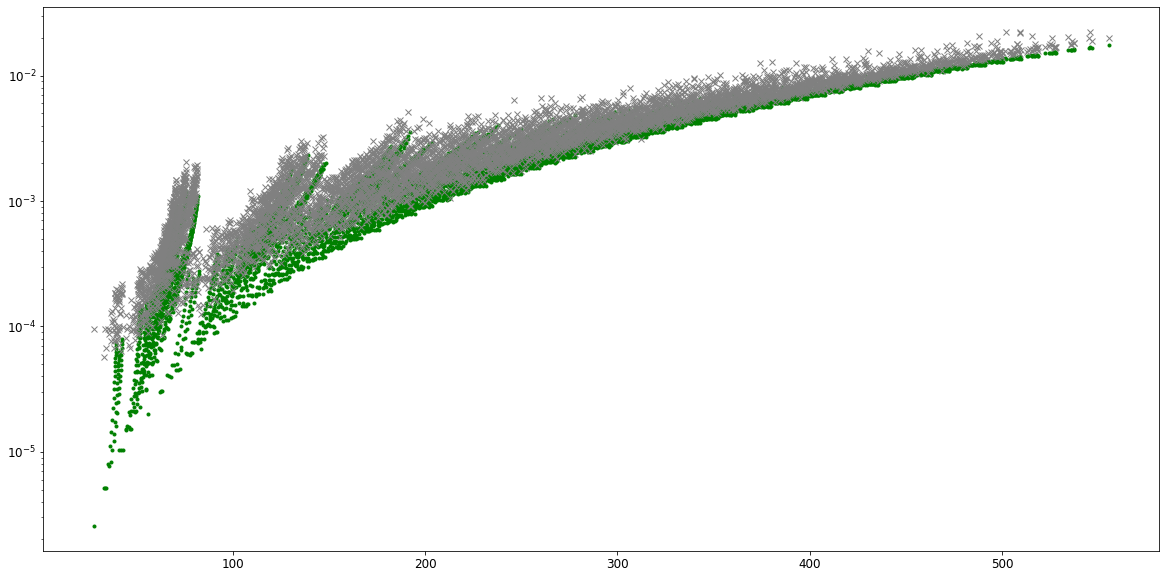

In [238]:
#plt.xlim(500,510)
plt.yscale('log')
#plot_quantile_compare2("data/gemm2000_shuffled_timeperf_std.txt")
#plt.plot(x2,y2[:,0],'.',color='r')
#plt.plot(tx_q1,ty_q1,'x',color='grey')
#plt.plot(x2,y2[:,1],'.',color='b')
#plt.plot(tx_q2,ty_q2,'x',color='grey')
plt.plot(x2,y2[:,2],'.',color='g')
plt.plot(tx_q3,ty_q3,'x',color='grey')
plt.show()

In [40]:
np.arange(50,2000,50)

array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
       1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650,
       1700, 1750, 1800, 1850, 1900, 1950])

In [90]:
out

array([ 90.98309141, 103.85910335, 113.07658636])

In [114]:
model.summary()


Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  1024      
_________________________________________________________________
dense_5 (Dense)              multiple                  32896     
_________________________________________________________________
dense_6 (Dense)              multiple                  8256      
_________________________________________________________________
dense_7 (Dense)              multiple                  195       
Total params: 42,371
Trainable params: 42,371
Non-trainable params: 0
_________________________________________________________________


### Save model

In [115]:
model.save_weights('./checkpoints/chp_gemm_mnk')

In [154]:
np.arange(50,1050,50)

array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])

In [173]:
len(x)

8000

In [167]:
len(tx_q1)

6572

### Deploy methods

In [196]:
def get_gt(M,N,K):
    filename = "data/gemm_mnk.txt"
    with open(filename) as f:
        lines = f.readlines()
        y = []
        for line in lines:

            m = float(line.split()[0])
            n = float(line.split()[1])
            k = float(line.split()[2])

            if (m==M and n==N and k==K):
                y.append(float(line.split()[3]))  

    y.sort()
    return y

In [198]:
def estimate_gemm(m,n,k):
    perfs_std = 20.44765391998221
    perfs_mean  = 87.79658425316

    eval_size = [m,n,k]
    inp = tf.constant(eval_size,shape=(1,3),dtype="float64")
    out = model(inp)
    out = out*perfs_std + perfs_mean
    t = float(2*m*n*k)*1e-9/out
    x_p = float(2*m*n*k)/(1.1*m*n + 1.2*n*k + 1.3*m*k)
    return (t.numpy(), x_p)

### Evaluation

$AB \qquad A \in \mathbb{R}^{m \times n} \quad B \in \mathbb{R}^{n \times k}$

In [233]:
M=900
N=950
K=950
estimate_gemm(M,N,K)

(array([[0.01806614, 0.01575529, 0.01456223]]), 518.1818181818181)

In [234]:
M=900
N=950
K=950
get_gt(M,N,K)

[0.015243800000000002,
 0.015284200000000001,
 0.015324500000000001,
 0.015329100000000002,
 0.015339700000000001,
 0.015375400000000001,
 0.015386100000000002,
 0.0154467,
 0.015454700000000002,
 0.0155422,
 0.0155475,
 0.0155724,
 0.015594400000000001,
 0.015851300000000002,
 0.0158991,
 0.016444200000000003,
 0.0165082,
 0.0165246,
 0.0177048,
 0.0238504]